# Corona in Hamburg

In [1]:
import datetime
import os
import re
import urllib.parse

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
CORONA_DATA_URL = "https://www.hamburg.de/corona-zahlen/"
MONTHS = ["Januar", "Februar", "März", "April", "Mai", "Juni",
          "Juli", "August", "September", "Oktober", "November", "Dezember"]
WEEKDAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
BOROUGHS = {
    "Altona": 275265,
    "Bergedorf": 130260,
    "Eimsbüttel": 267053,
    "Hamburg Mitte": 301546,
    "Hamburg Nord": 314595,
    "Harburg": 169426,
    "Wandsbek": 441015,
    "Hamburg": 1899160,
}

In [3]:
RESTRICTIONS = {
    datetime.date(2020, 3, 16): "schools closed",
    datetime.date(2020, 3, 23): "lockdown",
    datetime.date(2020, 4, 20): "lockdown end",
    datetime.date(2020, 4, 27): "masks required",
    datetime.date(2020, 10, 12): "masks required in more areas",
    datetime.date(2020, 10, 26): "contact restrictions",
    datetime.date(2020, 11, 2): "lockdown \"light\"",
}

In [4]:
def parse_data(src):
    soup = bs4.BeautifulSoup(src)
    historic_case_data_header = soup.find("h2", text="Inzidenz zum Download")
    if historic_case_data_header:
        df = pd.read_excel(
            urllib.parse.urljoin(
                CORONA_DATA_URL,
                historic_case_data_header.parent.find_next("div").a["href"]
            ),
            index_col=1,
            skiprows=[0],
            parse_dates=True
        )

        daily_cases = pd.read_csv("corona-hamburg-daily.csv", index_col=0, parse_dates=True)

        df = df.drop(
            set(df.columns) - {"Datum", "Gesamthaft gemeldete SARS-CoV-2 Infektionen"},
            axis="columns"
        ).rename(columns={
            "Datum": "date",
            "Gesamthaft gemeldete SARS-CoV-2 Infektionen": "cases"
        })

        date = pd.DateOffset(days=-1).apply(df.index[0])
        df.loc[date] = daily_cases.cumsum().loc[date]
        df = df.dropna().sort_index().diff().dropna().astype(int)

        daily_cases.update(df)
        daily_cases.astype(int).to_csv("corona-hamburg-daily.csv")

    header = soup.find("h2", text="Neue Fälle: Sieben Tage Chart")
    if not header:
        header = soup.find("h2", text="Neue Fälle: Sieben Tage Inzidenz")

    if header:
        values = [el.text.strip() for el in soup.find_all(attrs={"class": "value_show"})]
        par = soup.find(lambda el: el.name == "p" and el.text.strip().startswith("Bei der Inzidenz"))
        if values and par:
            date = datetime.datetime.strptime(par.find_all("strong")[1].text[1:-1], "%d.%m.%Y").date()
            dates = reversed([(date - datetime.timedelta(days=d)).isoformat() for d in range(7)])

            with open("corona-hamburg-daily.csv", "r") as f:
                lines = [line.strip() for line in f]

            with open("corona-hamburg-daily.csv", "a") as f:
                for line in [f"{d},{val}" for d, val in zip(dates, values)]:
                    if line not in lines:
                        f.write(f"{line}\n")

    header = soup.find("h3", text="Entwicklung der Zahl der positiv auf COVID-19 getesteten Personen nach Bezirken")
    if header:
        table = header.parent.find("table")
        timestamp = table.parent.parent.find_all("p")[-1].text.replace("Stand:", "")
        timestamp = re.sub(r"[.,]+", " ", timestamp).split()
        timestamp = f"{timestamp[2]}-{MONTHS.index(timestamp[1])+1:0>2}-{int(timestamp[0]):0>2}"
        total_cases = [timestamp,"total"]
        active_cases = [timestamp,"active"]
        for row in table.find_all("tr"):
            borough = row.find(attrs={"data-label": "Bezirk"})
            if not borough:
                continue
            cases = row.find(attrs={"data-label": "Fallzahlen"})
            if cases:
                total_cases.append(cases.text.strip())
            cases = (
                row.find(attrs={"data-label": "Fälle vergangene 14 Tage"})
                or row.find(attrs={"data-label": "Fälle letzte 14 Tage"})
            )
            if cases:
                active_cases.append(cases.text.strip())

        with open("corona-hamburg.csv") as f:
            lines = [line.strip() for line in f]
        
        with open("corona-hamburg.csv", "a") as f:
            total_cases_line = ",".join(total_cases)
            if total_cases_line not in lines and len(total_cases) > 2:
                f.write(f"{total_cases_line}\n")

            active_cases_line = ",".join(active_cases)
            if active_cases_line not in lines and len(active_cases) > 2:
                f.write(f"{active_cases_line}\n")

In [5]:
r = requests.get(CORONA_DATA_URL)
if r.ok:
    parse_data(r.text)

In [6]:
daily_cases = pd.read_csv("corona-hamburg-daily.csv", index_col=0, parse_dates=True)
daily_cases_rolling7 = daily_cases.rolling(7).sum().dropna()

In [7]:
df = pd.read_csv("corona-hamburg.csv", index_col=0, parse_dates=True)
total_cases = df[df["type"] == "total"].drop(["type"], axis="columns").astype(int)
new_cases = total_cases.diff().dropna().astype(int)

In [8]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## Total Cases

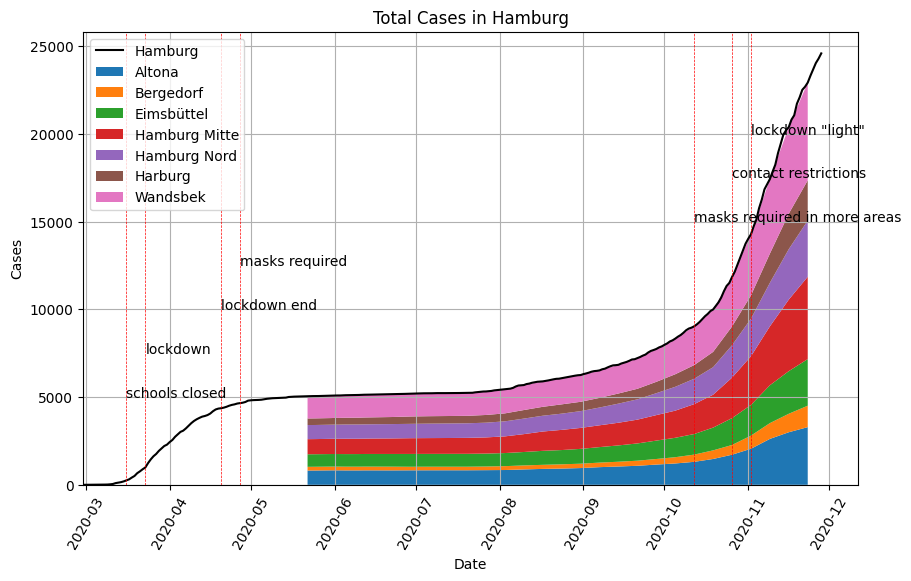

In [9]:
plt.figure()
plt.title("Total Cases in Hamburg")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.stackplot(total_cases.index, *total_cases.values.T, labels=total_cases.columns)
plt.plot(daily_cases.index, daily_cases.cumsum().values, "black", label="Hamburg")
y = 5000
dy = 2500 # (daily_cases.cumsum().values.max() - 5000) / (len(RESTRICTIONS) - 1)
for date in RESTRICTIONS:
    plt.axvline(x=date, color="red", linestyle="dashed", linewidth=0.5)
    plt.annotate(RESTRICTIONS[date], (date, y))
    y += dy
    plt.legend(loc="upper left")
plt.legend(loc="upper left")
plt.xlim(xmin=daily_cases.index[0])
plt.xticks(rotation=60)
plt.grid()
plt.show()

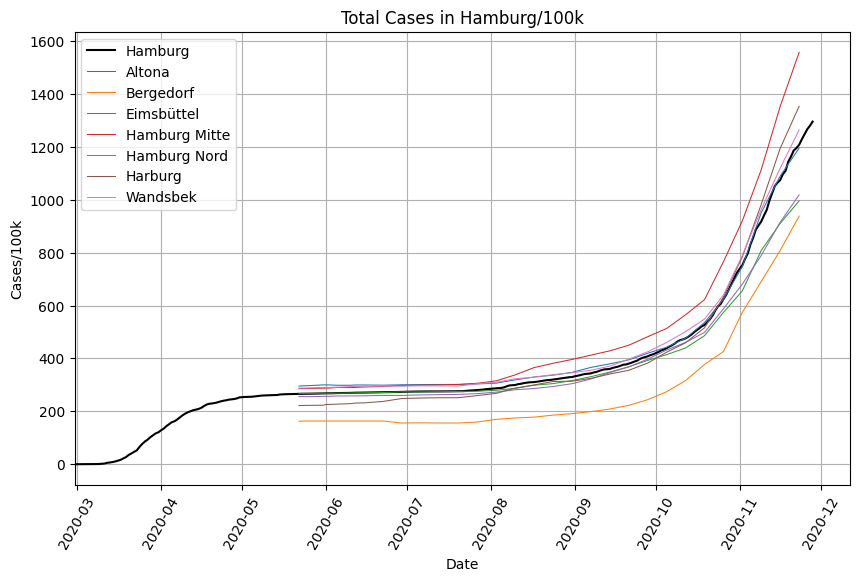

In [10]:
plt.figure()
plt.title("Total Cases in Hamburg/100k")
plt.xlabel("Date")
plt.ylabel("Cases/100k")
plt.plot(daily_cases.index, daily_cases.cumsum().values / BOROUGHS["Hamburg"] * 1e5, "black", label="Hamburg")
for borough in new_cases.columns:
    plt.plot(total_cases.index, total_cases[borough] / BOROUGHS[borough] * 1e5, label=borough, lw=0.75)
plt.legend(loc="upper left")
plt.xlim(xmin=daily_cases.index[0])
plt.xticks(rotation=60)
plt.grid()
plt.show()

In [11]:
total_cases["Hamburg"] = total_cases.sum("columns")
total_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-09-21,1086,290,984,1357,1158,602,1752,7229
2020-09-28,1155,318,1049,1454,1250,648,1875,7749
2020-10-05,1218,357,1107,1548,1359,718,2031,8338
2020-10-12,1311,412,1174,1704,1449,778,2212,9040
2020-10-19,1474,491,1298,1876,1568,874,2420,10001
2020-10-26,1717,555,1532,2308,1849,1071,2820,11852
2020-11-02,2057,748,1751,2775,2142,1329,3484,14286
2020-11-09,2619,900,2159,3359,2484,1665,4251,17437
2020-11-16,3000,1053,2432,4080,2879,2024,4938,20406


In [12]:
daily_cases.cumsum().tail(8).T

date,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27,2020-11-28
cases,22530,22702,22939,23331,23694,24054,24306,24606


## New Cases

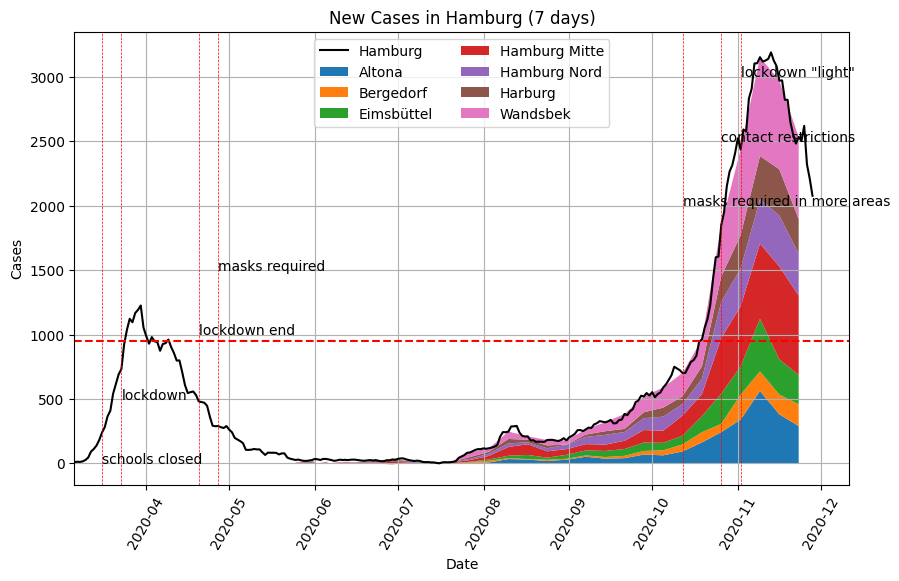

In [13]:
plt.figure()
plt.title("New Cases in Hamburg (7 days)")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.stackplot(new_cases.index, *new_cases.values.T, labels=new_cases.columns)
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values, "black", label="Hamburg")
plt.axhline(y=950, c="r", ls="dashed")
y = 0
dy = 500 # daily_cases_rolling7.values.max() / (len(RESTRICTIONS) - 1)
for date in RESTRICTIONS:
    plt.axvline(x=date, c="r", ls="--", lw=0.5)
    plt.annotate(RESTRICTIONS[date], (date, y))
    y += dy
plt.legend(loc="upper center", ncol=2)
plt.xlim(xmin=daily_cases_rolling7.index[0])
plt.xticks(rotation=60)
plt.grid()
plt.show()

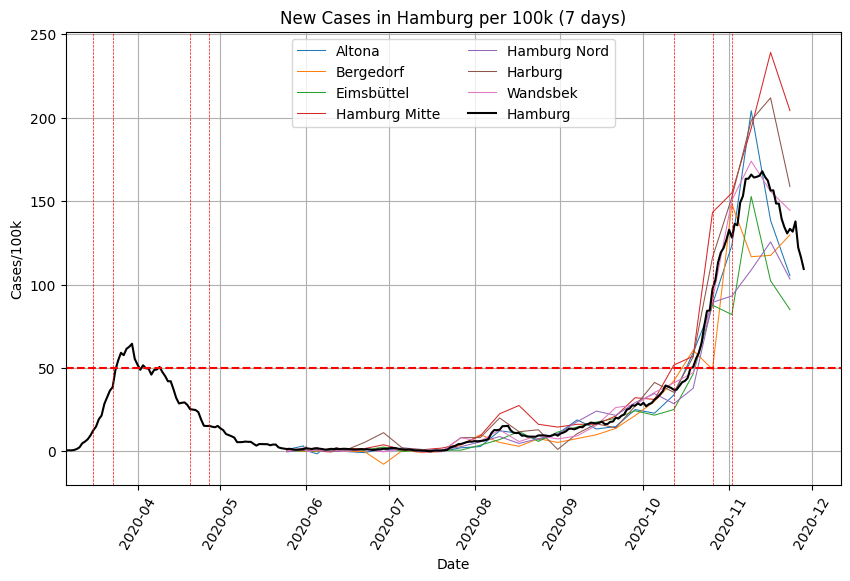

In [14]:
plt.figure()
for borough in new_cases.columns:
    plt.plot(new_cases.index, new_cases[borough] / BOROUGHS[borough] * 1e5, label=borough, lw=0.75)
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values / BOROUGHS["Hamburg"] * 1e5, "k-", label="Hamburg")
plt.axhline(y=50, c="r", ls="--")
for date in RESTRICTIONS:
    plt.axvline(x=date, c="r", ls="--", lw=0.5)
plt.title("New Cases in Hamburg per 100k (7 days)")
plt.legend(loc="upper center", ncol=2)
plt.xlabel("Date")
plt.ylabel("Cases/100k")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases_rolling7.index[0])
plt.grid()
plt.show()

In [15]:
new_cases["Hamburg"] = new_cases.sum("columns")
new_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-09-21,41,18,53,64,68,24,116,384
2020-09-28,69,28,65,97,92,46,123,520
2020-10-05,63,39,58,94,109,70,156,589
2020-10-12,93,55,67,156,90,60,181,702
2020-10-19,163,79,124,172,119,96,208,961
2020-10-26,243,64,234,432,281,197,400,1851
2020-11-02,340,193,219,467,293,258,664,2434
2020-11-09,562,152,408,584,342,336,767,3151
2020-11-16,381,153,273,721,395,359,687,2969


In [16]:
(new_cases / pd.DataFrame(BOROUGHS, index=new_cases.index) * 1e5).round(2).tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-09-21,14.89,13.82,19.85,21.22,21.62,14.17,26.30,20.22
2020-09-28,25.07,21.50,24.34,32.17,29.24,27.15,27.89,27.38
2020-10-05,22.89,29.94,21.72,31.17,34.65,41.32,35.37,31.01
2020-10-12,33.79,42.22,25.09,51.73,28.61,35.41,41.04,36.96
2020-10-19,59.22,60.65,46.43,57.04,37.83,56.66,47.16,50.60
2020-10-26,88.28,49.13,87.62,143.26,89.32,116.27,90.70,97.46
2020-11-02,123.52,148.17,82.01,154.87,93.14,152.28,150.56,128.16
2020-11-09,204.17,116.69,152.78,193.67,108.71,198.32,173.92,165.92
2020-11-16,138.41,117.46,102.23,239.10,125.56,211.89,155.78,156.33


In [17]:
daily_cases_rolling7.tail(8).T

date,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27,2020-11-28
cases,2552.0,2481.0,2533.0,2501.0,2618.0,2319.0,2209.0,2076.0


In [18]:
df = (daily_cases_rolling7 / BOROUGHS["Hamburg"] * 1e5).round(2)
df["weekday"] = df.index.day_name()
df["week"] = df.index.week
df.pivot(index="week", columns=["weekday"])["cases"][WEEKDAYS].loc[42:]

weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
week,,,,,,,
42,36.96,36.96,39.18,41.44,42.23,43.97,49.76
43,50.60,55.45,58.92,64.61,75.14,84.20,84.51
44,97.46,102.52,113.21,119.21,121.84,126.74,132.80
45,128.16,136.38,135.53,149.07,153.02,163.34,163.44
46,165.92,164.13,164.55,165.23,167.86,164.49,162.28
47,156.33,156.44,148.54,148.49,139.38,134.38,130.64
48,133.37,131.69,137.85,122.11,116.31,109.31,NaN


## Daily Cases

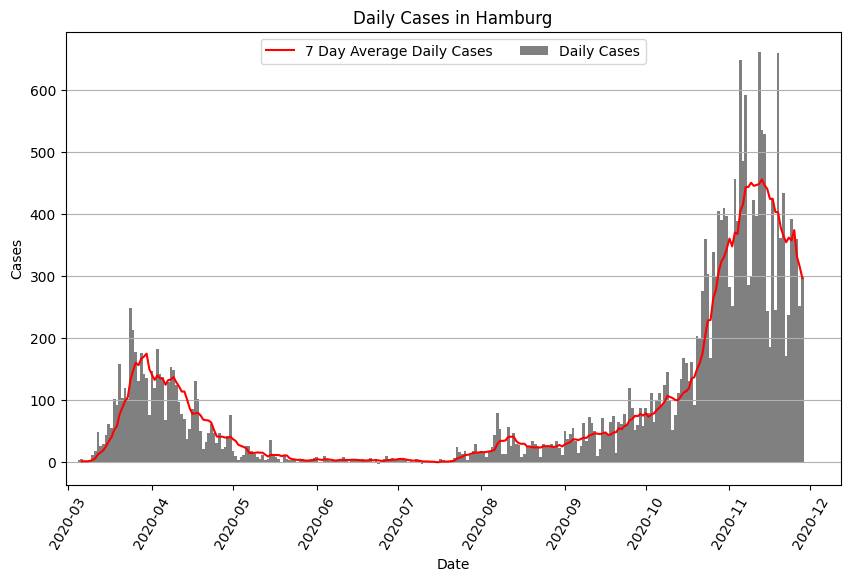

In [19]:
plt.figure()
plt.bar(daily_cases.index, daily_cases.values.T[0], width=1, color="grey", label="Daily Cases")
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7 / 7, "red", label="7 Day Average Daily Cases")
plt.title("Daily Cases in Hamburg")
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases.index[0])
plt.grid(axis="y")
plt.show()

In [20]:
df = daily_cases.copy()
df["weekday"] = df.index.day_name()
df["week"] = df.index.week
df = df.pivot(index="week", columns=["weekday"])["cases"][WEEKDAYS]
df["mean"] = df.mean(axis=1).round(2)
df.loc[42:]

weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,mean
week,,,,,,,,
42,77.0,112.0,135.0,168.0,160.0,131.0,162.0,135.00
43,93.0,204.0,201.0,276.0,360.0,303.0,168.0,229.29
44,339.0,300.0,404.0,390.0,410.0,396.0,283.0,360.29
45,251.0,456.0,388.0,647.0,485.0,592.0,285.0,443.43
46,298.0,422.0,396.0,660.0,535.0,528.0,243.0,440.29
47,185.0,424.0,246.0,659.0,362.0,433.0,172.0,354.43
48,237.0,392.0,363.0,360.0,252.0,300.0,NaN,317.33


In [21]:
(daily_cases_rolling7 / 7).tail(8).T.round(2)

date,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27,2020-11-28
cases,364.57,354.43,361.86,357.29,374.0,331.29,315.57,296.57
